# Importing Librarys

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas import DataFrame
import itertools
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from math import sqrt
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

# Analysis imports
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore') #this would remove any deprecated warning

In [4]:
data_gld = pd.read_csv('GLD.csv')
print("GLD Data: " + str(data_gld.shape))
data_gld.head(20)

GLD Data: (3780, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
3,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
4,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100
5,2004-11-26,45.250000,45.599998,45.060001,45.290001,45.290001,3097700
6,2004-11-29,45.099998,45.500000,45.080002,45.400002,45.400002,3759000
7,2004-11-30,45.369999,45.410000,44.820000,45.119999,45.119999,3857200
8,2004-12-01,45.279999,45.590000,45.259998,45.380001,45.380001,2037500
9,2004-12-02,45.549999,45.570000,44.680000,44.950001,44.950001,6457800


In [5]:
data_gld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3780 non-null   object 
 1   Open       3780 non-null   float64
 2   High       3780 non-null   float64
 3   Low        3780 non-null   float64
 4   Close      3780 non-null   float64
 5   Adj Close  3780 non-null   float64
 6   Volume     3780 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 206.8+ KB


In [6]:
data_gld.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3.780000e+03
mean,109.298553,109.854220,108.700423,109.297146,109.297146,9.677284e+06
std,33.461304,33.575604,33.326566,33.458163,33.458163,7.196708e+06
min,41.029999,41.360001,41.020000,41.259998,41.259998,3.193000e+05
25%,87.362501,88.407504,86.715000,87.419998,87.419998,5.089775e+06
50%,117.024998,117.444999,116.420002,116.985000,116.985000,7.992400e+06
75%,127.002500,127.532500,126.432501,127.127503,127.127503,1.205778e+07
max,184.580002,185.850006,182.100006,184.589996,184.589996,9.380420e+07


In [7]:
print("Dataframe contains GLD Data from from " + str(data_gld['Date'].min()) + " to " + str(data_gld['Date'].max()))

Dataframe contains GLD Data from from 2004-11-18 to 2019-11-22


In [8]:
# Read in csv file and parse date as datetime
dateparser = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
ffill_data = pd.read_csv('GLD.csv', parse_dates=['Date'], date_parser=dateparser)
print("GLD Data Before Forward Fill: " + str(ffill_data.shape))


cols = ffill_data.columns #store original column names
ffill_data.set_index("Date", inplace=True)
ffill_data.head(10)

GLD Data Before Forward Fill: (3780, 7)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100
2004-11-26,45.250000,45.599998,45.060001,45.290001,45.290001,3097700
2004-11-29,45.099998,45.500000,45.080002,45.400002,45.400002,3759000
2004-11-30,45.369999,45.410000,44.820000,45.119999,45.119999,3857200
2004-12-01,45.279999,45.590000,45.259998,45.380001,45.380001,2037500


In [9]:
# Resample dates and forward fill missing values with previous values
ffill_data = ffill_data.resample("D").ffill().reset_index()

In [10]:
print("GLD Data After Forward Fill: " + str(ffill_data.shape))
ffill_data.head(10)

GLD Data After Forward Fill: (5483, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2,2004-11-20,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
3,2004-11-21,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
4,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
5,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
6,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100
7,2004-11-25,44.930000,45.049999,44.790001,45.049999,45.049999,6105100
8,2004-11-26,45.250000,45.599998,45.060001,45.290001,45.290001,3097700
9,2004-11-27,45.250000,45.599998,45.060001,45.290001,45.290001,3097700


In [11]:
# Sort by date in ascending order & export to new csv file
ffill_data = ffill_data[cols] #revert column order
ffill_data.sort_values(by='Date', inplace=True)
ffill_data.to_csv('gld-nomissing.csv', index=False)

# EDA Conclusion
- the original csv file used to have 3780 rows of data. After filling the missing dates, we now have 5483 rows of data.

# Visualize The Data

In [12]:
# Read in the gld prices file with no missing data
# Convert the date column from string to date and make it the index
dateparser = lambda dates: pd.to_datetime(dates,format='%Y-%m-%d')
data = pd.read_csv('gld-nomissing.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparser)
print("GLD Prices for All Days, including weekends and holidays: " + str(data.shape))
data.head()


GLD Prices for All Days, including weekends and holidays: (5483, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-20,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-21,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000


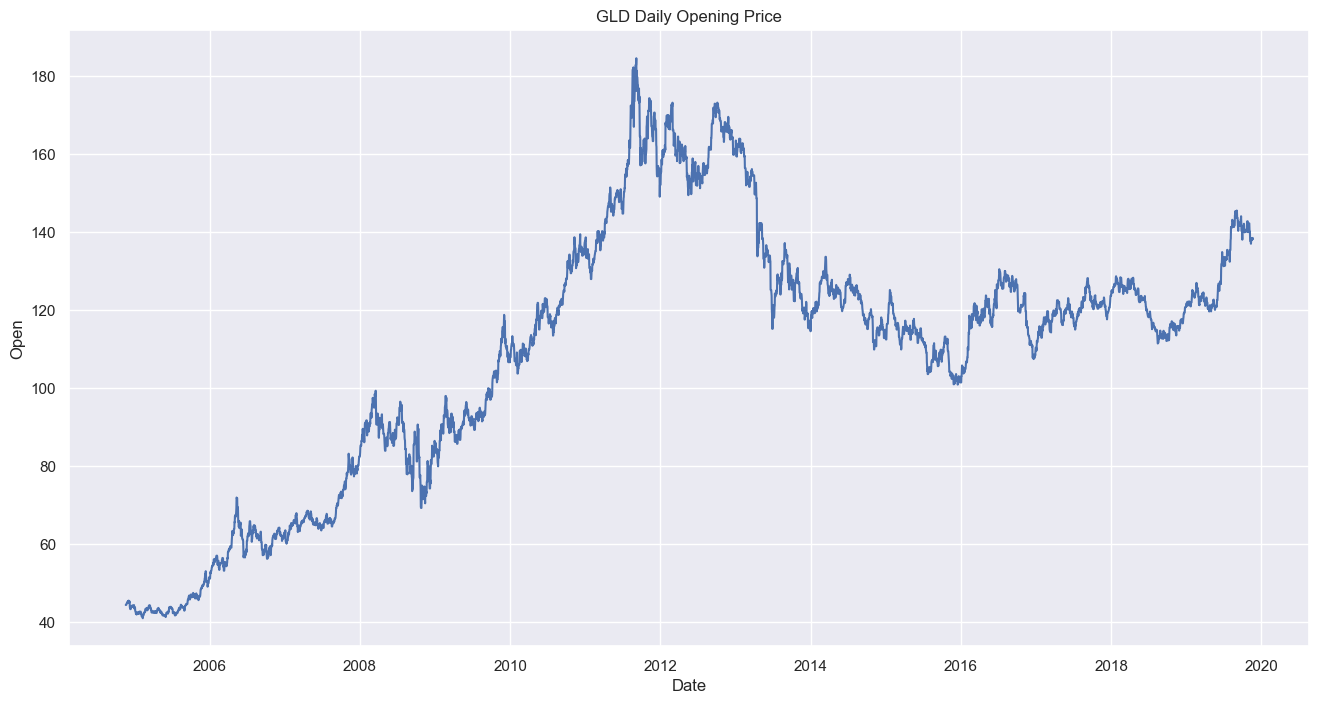

In [13]:
sns.set(style="darkgrid")
plt.figure(figsize=(16,8))
sns.lineplot(x=data.index, y='Open', data=data, linewidth=1.5).set_title('GLD Daily Opening Price')
plt.show()

# Check If Time Series Data is Stationary
Data needs to be stationary before modeling. Run Dicky-Fuller test on the Open Price

In [14]:
adfuller_result = adfuller(data['Open'])
print('ADF Statistic: ', adfuller_result[0])
print('p-value: ', round(adfuller_result[1]*100,2),'%')

ADF Statistic:  -1.8025174981713021
p-value:  37.92 %


### Conclusion: The data is not stationary because the p-value is greater than 0.05

# Make the Time Series Data Stationary
Use the difference method, square root and take the difference twice method to see which is a best way to make the data stationary

In [15]:
# Diff Method
data_diff = data.diff().dropna()
diff_adfuller_result = adfuller(data_diff['Open'])
print('Difference Method ADF Statistic: ', diff_adfuller_result[0])
print('Difference Method p-value: ', diff_adfuller_result[1])

Difference Method ADF Statistic:  -16.738250093306693
Difference Method p-value:  1.3650617859603262e-29


In [16]:
data_sqrt = np.sqrt(data).dropna()
sqrt_adfuller_result = adfuller(data_sqrt['Open'])
print('Square Root Method ADF Statistic: ', sqrt_adfuller_result[0])
print('Square Root Methodp-value: ', round(sqrt_adfuller_result[1]*100,2),'%')

Square Root Method ADF Statistic:  -2.0279705213801664
Square Root Methodp-value:  27.44 %


In [17]:
# Diff Twice Method
data_difftwice = data.diff().diff().dropna()
difftwice_adfuller_result = adfuller(data_difftwice['Open'])
print('Difference Method ADF Statistic: ', difftwice_adfuller_result[0])
print('Difference Method p-value: ', difftwice_adfuller_result[1])

Difference Method ADF Statistic:  -21.13672510562544
Difference Method p-value:  0.0


### Conclusion
The Square Root methods didn't produce a p-value less than 0.05. So we should eliminate it. Both Differencing once and twice methods produced a p-value less than 0.05 but Differencing Twice produced a much more negative ADF Statistic. That's what we want, the more negative the better.

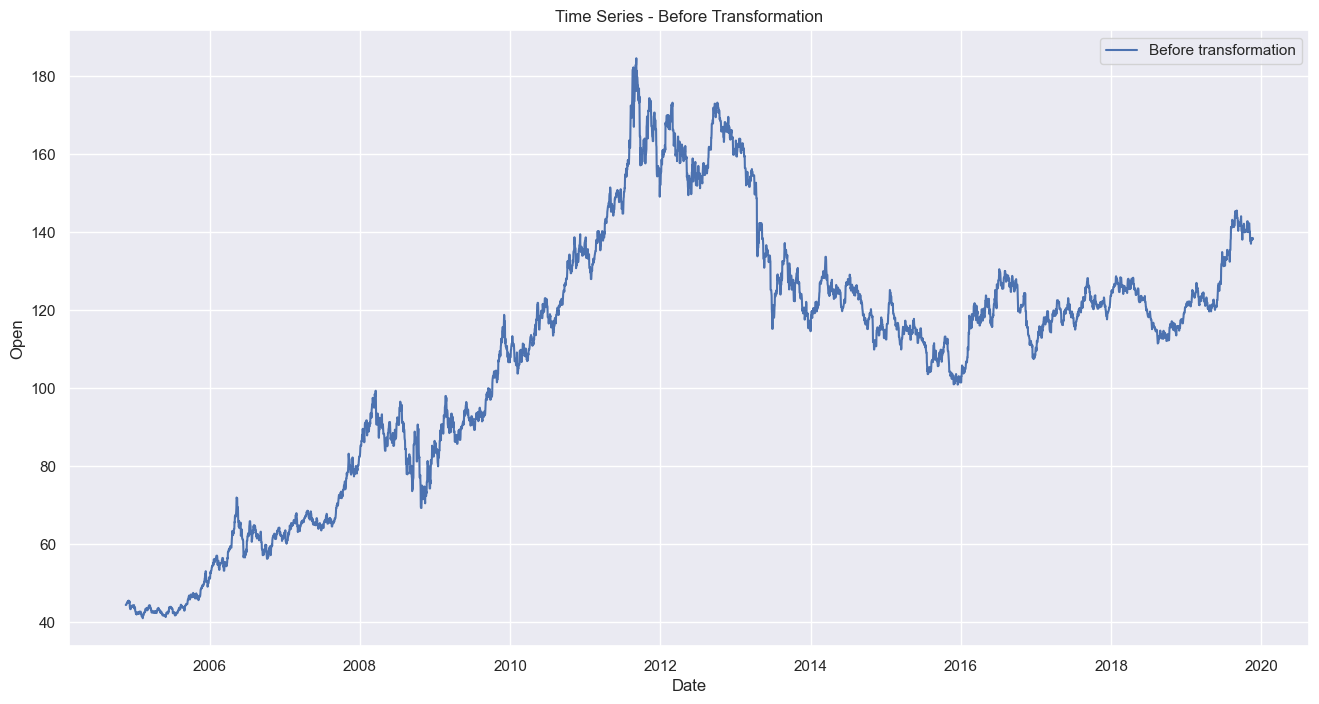

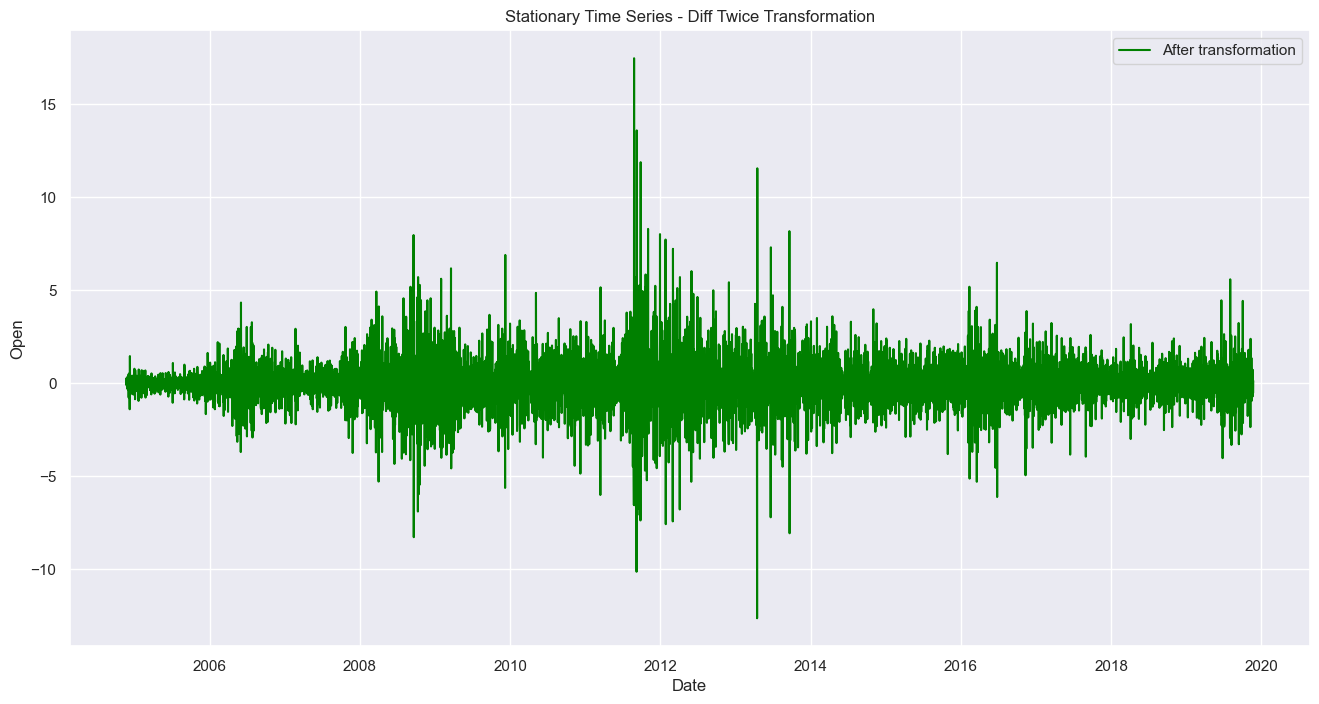

In [18]:
# Plot the time series before transformation
plt.figure(figsize=(16,8))
sns.lineplot(x=data.index, y='Open', data=data, linewidth=1.5, label='Before transformation').set_title('Time Series - Before Transformation')
plt.show()

# Plot the time series after transformation
plt.figure(figsize=(16,8))
sns.lineplot(x=data_difftwice.index, y='Open', data=data_difftwice, label='After transformation', color='green').set_title('Stationary Time Series - Diff Twice Transformation')
plt.show()

# Which Model - AR, MA or ARMA. Use ACF and PACF to Choose the Model Order

**ACF** - Autocorrelation function to help select the right order.

**PACF** - Partial Autocorrelation is the correlation between the time series and the lag version of itself after we subtract the effect of correlation at smaller lags.So, it’s just the correlation associated with just that particular lag

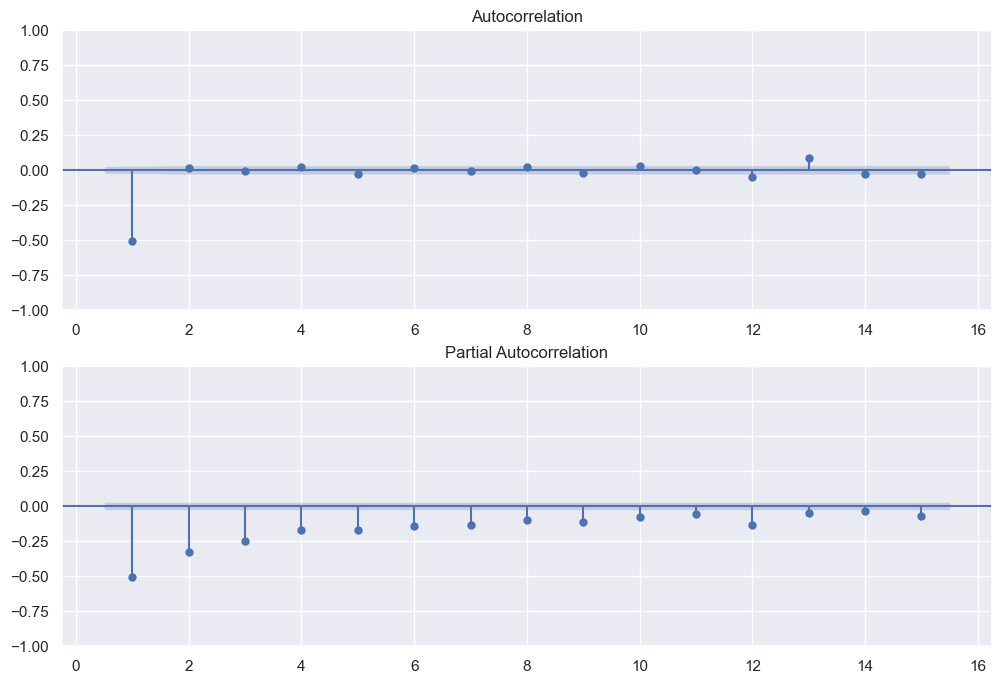

In [19]:
# Plot ACF and PACF with stationary data using data that was differenced twice

fig_difftwice, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF of data_difftwice
plot_acf(data_difftwice['Open'], lags=15, zero=False, ax=ax1, title='Autocorrelation')

# Plot PACF of data_difftwice
plot_pacf(data_difftwice['Open'], lags=15, zero=False, ax=ax2, title='Partial Autocorrelation')

plt.show()

### Initial Observation
**ACF** - Cuts off after lag 1

**PACF** - tails off

**Initial conclusion:** It may be a MA(1) model.

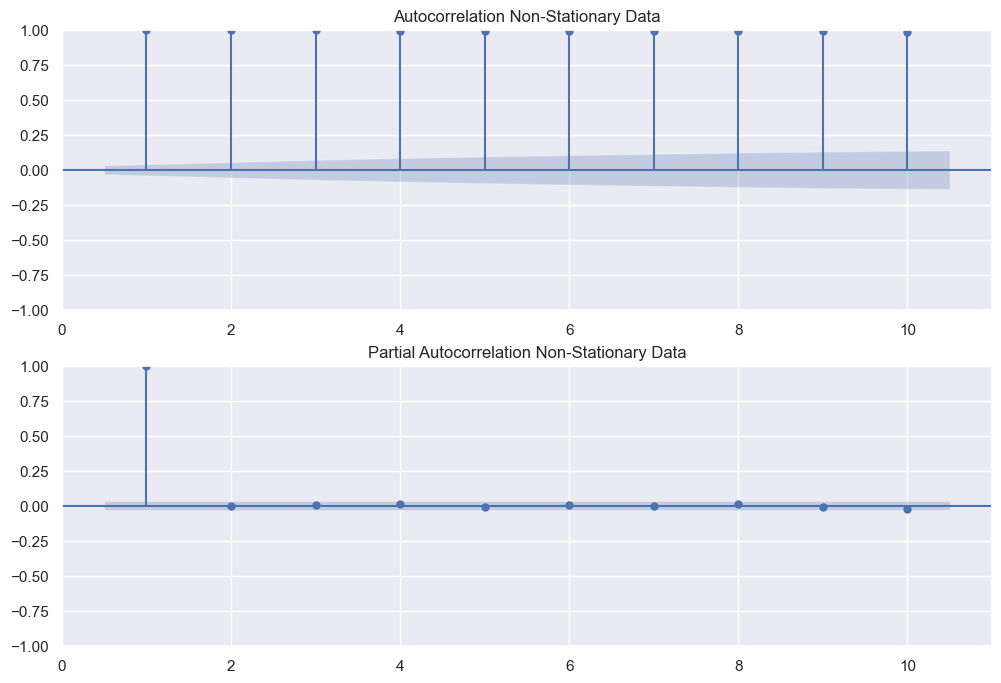

In [20]:
# Plot ACF and PACF with non-stationary data just to see how different they are compared to the stationary data

fig_data_gld, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF of data_difftwice
plot_acf(data_gld['Open'], lags=10, zero=False, ax=ax1, title='Autocorrelation Non-Stationary Data')

# Plot PACF of data_difftwice
plot_pacf(data_gld['Open'], lags=10, zero=False, ax=ax2, title='Partial Autocorrelation Non-Stationary Data')

plt.show()

# Conclusion
The **ACF** cuts off after lag 1 and the **PACF** tails off. This may indicate that a Moving Average Model with an order of 1 MA(1) might be the best. However, there are limitations to the ACF and PACF method. We are making the judgement based on how the ACF and PACF graphs look. Sometimes it may not be as clear to make a conclusion. 

Next, let's use a different method to pick the optimal model order - the AIC and BIC.

# Which Model - AR, MA or ARMA. Use AIC and BIC Results to Pick the Optimal Model Order

**Akaike Information Criterion (AIC)**
- Lower AIC indicates a better model
- AIC is ideal for simple models with lower order


**Bayesian Information Criterion (BIC)**
- Lower BIC indicates a better model
- BIC penalizes complex models

Most of the times, AIC and BIC will select the same model order. However, when they don't, we have to make a choice which to pick:
- AIC - better at choosing predictive models (use this if that’s our goal)
- BIC - better at choosing good explanatory model (use this if that’s our goal)



# Conclusion: Both AIC and BIC selected the same p and q values of 0, 1.
This is the same results as the ACF and PACF analysis where we determined it was a MA(1) model order.

# Train-test Split
There are 15 years of data. We are going to use the first 12 years (2004 - 2016) as training data and the last 3 years (2017 - 2019) as test data.

In [21]:
train_data = data.loc[:'2016']
test_data = data.loc['2017':]

In [22]:
# Look at train data
train_data.shape

(4427, 6)

In [23]:
# Checking to make sure the data ends in 2016
train_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-27,108.610001,108.669998,108.239998,108.559998,108.559998,3685500
2016-12-28,108.400002,108.910004,108.290001,108.860001,108.860001,5091200
2016-12-29,109.230003,110.529999,109.160004,110.290001,110.290001,7563900
2016-12-30,110.379997,110.620003,109.529999,109.610001,109.610001,8873700
2016-12-31,110.379997,110.620003,109.529999,109.610001,109.610001,8873700


In [24]:
# Look at test data
test_data.shape

(1056, 6)

In [25]:
# Check to see the data starts in 2017
test_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,110.379997,110.620003,109.529999,109.610001,109.610001,8873700
2017-01-02,110.379997,110.620003,109.529999,109.610001,109.610001,8873700
2017-01-03,109.620003,111.000000,109.370003,110.470001,110.470001,7527400
2017-01-04,111.059998,111.220001,110.610001,110.860001,110.860001,4904100
2017-01-05,112.160004,112.940002,112.070000,112.580002,112.580002,9606800


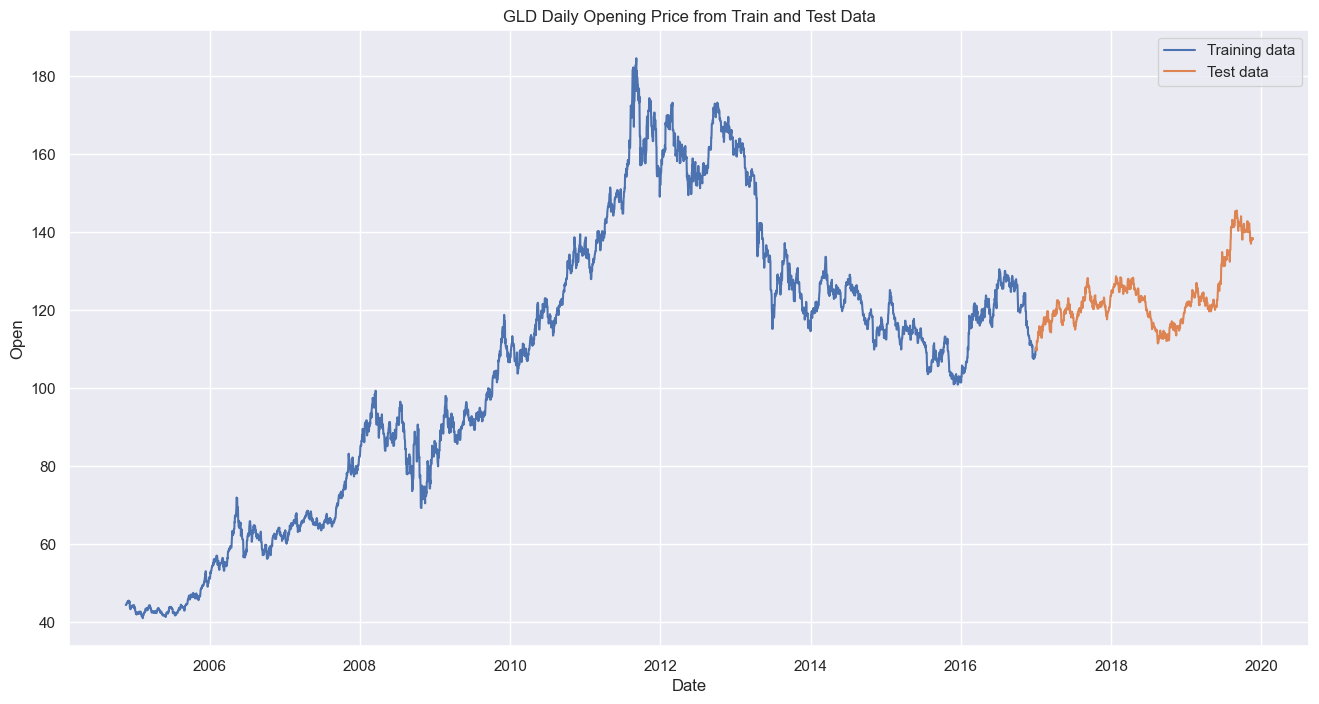

In [26]:
# Plot the test and train data
plt.figure(figsize=(16,8))
sns.lineplot(x=train_data.index, y='Open', data=train_data, linewidth=1.5, label='Training data').set_title('GLD Daily Opening Price from Train and Test Data')
sns.lineplot(x=test_data.index, y='Open', data=test_data, linewidth=1.5, label='Test data')
plt.show()

# Method 1: ARMA Model& Forecast

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Fit 
ar_order = (1,0,0)  # Replace p with the desired order for autoregressive (AR) component
ar_model = ARIMA(train_data['Open'], order=ar_order)
ar_results = ar_model.fit()


# Make predictions for the last 365 days of the train data
pred_365_traindata_arma = ar_results.get_prediction(start=-365, dynamic=False)

# Forecast mean for these 365 days
pred_mean_365_traindata_arma = pred_365_traindata_arma.predicted_mean

# Get confidence intervals of forecast
confidence_intervals_arma = pred_365_traindata_arma.conf_int()

# Select lower and upper confidence limits
lower_limits_arma = confidence_intervals_arma.loc[:, 'lower Open']
upper_limits_arma = confidence_intervals_arma.loc[:, 'upper Open']



In [28]:
print(pred_mean_365_traindata_arma)

2016-01-02    101.480713
2016-01-03    101.480713
2016-01-04    101.480713
2016-01-05    103.130076
2016-01-06    103.130076
                 ...    
2016-12-27    107.838274
2016-12-28    108.607984
2016-12-29    108.398066
2016-12-30    109.227749
2016-12-31    110.377303
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


In [29]:
# Convert pred_mean_365_traindata series to a dataframe
# Inspect pred_mean_365_traindata_df
pred_mean_365_traindata_df = pred_mean_365_traindata_arma.to_frame(name='forecasted_mean')
pred_mean_365_traindata_df.head()

,forecasted_mean
2016-01-02,101.480713
2016-01-03,101.480713
2016-01-04,101.480713
2016-01-05,103.130076
2016-01-06,103.130076


Overall, the above forecasts align with the true values very well for the last 365 days of the training data and it falls within the confidence intervals.

In [33]:
print(ar_results.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 4427
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6677.590
Date:                Tue, 02 Jan 2024   AIC                          13361.179
Time:                        10:34:20   BIC                          13380.365
Sample:                    11-18-2004   HQIC                         13367.945
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.3367     23.355      4.425      0.000      57.561     149.112
ar.L1          0.9996      0.000   2814.282      0.000       0.999       1.000
sigma2         1.1939      0.010    124.498      0.0

# Forecast using Training Data and Compare with the Test Data

In [35]:
# Forecasting out of the sample. Use 1056 because that's how many days there are in the test set
auto_arima_forecast = ar_results.get_forecast(steps=len(test_data))

# Forecast mean
auto_arima_mean_forecast = auto_arima_forecast.predicted_mean

# Get confidence intervals of forecast
# Assign it the same index at test data
auto_arima_forecasted_confidence_intervals = auto_arima_forecast.conf_int()
auto_arima_forecasted_confidence_intervals.index = test_data.index #need to do this in order to plot


# Select lower and upper confidence limits
auto_arima_forecasted_lower_limits = auto_arima_forecasted_confidence_intervals.loc[:,'lower Open']
auto_arima_forecasted_upper_limits = auto_arima_forecasted_confidence_intervals.loc[:,'upper Open']

# Convert auto_arima_mean_forecast to a dataframe
# Inspect auto_arima_mean_forecast
auto_arima_mean_forecast_df = auto_arima_mean_forecast.to_frame(name='forecasted_mean')
auto_arima_mean_forecast_df.index = test_data.index
auto_arima_mean_forecast_df.head()

,forecasted_mean
Date,
2017-01-01,110.377303
2017-01-02,110.374611
2017-01-03,110.371919
2017-01-04,110.369229
2017-01-05,110.366539


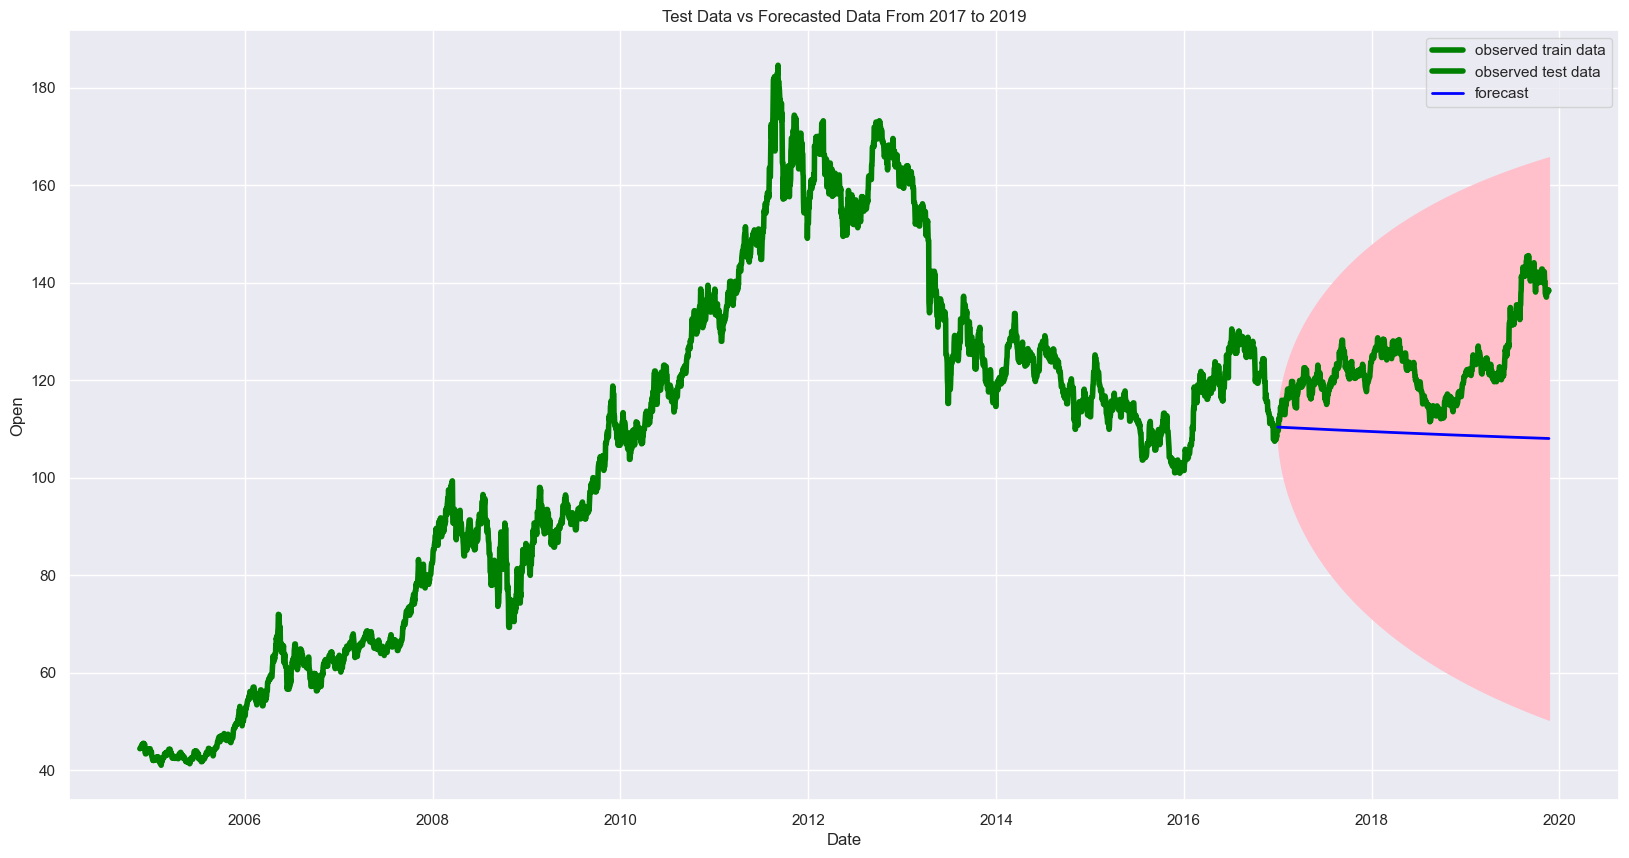

In [36]:
# Plot the forecasted data set against the test data
plt.figure(figsize=(20,10))

# Plot the train data
sns.lineplot(x=train_data.index, y='Open', data=train_data, linewidth=4, label='observed train data',color = 'green').set_title('Test Data vs Forecasted Data From 2017 to 2019')

# Plot the test data
sns.lineplot(x=test_data.index, y='Open', data=test_data, linewidth=4, label='observed test data',color = 'green')

# Plot the forecast data
sns.lineplot(x=auto_arima_mean_forecast_df.index, y=auto_arima_mean_forecast_df['forecasted_mean'], data=auto_arima_mean_forecast_df, linewidth=2, label='forecast', color='blue')

# Shade the area between the confidence intervals
plt.fill_between(auto_arima_forecasted_lower_limits.index, auto_arima_forecasted_lower_limits, auto_arima_forecasted_upper_limits, color='pink')

In [37]:
# Calculate MAE, MSE, RMSE
real_test_values = test_data['Open']

# Calculate MAE, MSE, RMSE
print('MAE: {}'.format(mean_absolute_error(real_test_values, auto_arima_mean_forecast)))
print('MSE: {}'.format(mean_squared_error(real_test_values, auto_arima_mean_forecast)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(real_test_values, auto_arima_mean_forecast))))

MAE: 14.081918372243198
MSE: 264.5115156588085
RMSE: 16.26380999823868


# ARIMA Conclusion
By looking at the plot, the forecasted data showed an upward trend which is aligned with the test data. It correctly predicted that Gold Prices will go up from 2017 - 2019. It is also within the confidence interval, however the interval is really large. It's hard to predict the prices of gold but it's able to predict a general trend over time.